In [1]:
import pandas as pd
import numpy as np

data = pd.read_parquet("../data/albania_res.parquet")

In [2]:
data.index = pd.to_datetime(data.index, utc="UTC")

In [3]:
from mlpforecast.data.transform import DatasetObjective
from sklearn.preprocessing import MinMaxScaler, RobustScaler

config_dict = {
    "target_series": "NetLoad",
    "unknown_features": ["NetLoad_rolling_mean_win_48", "NetLoad_rolling_mean_win_336"],
    "calender_variable": ["HOUR", "Session"],
    "known_calender_features": ["HOUR-cosin", "Session-cosin"],
    "known_continuous_features": [
        "NetLoad_lag_48",
        "NetLoad_lag_336",
        "Temperature",
        "Humidity",
        "Rain",
    ],
    "input_scaler": RobustScaler(),
    "target_scaler": RobustScaler(),
    "lags": [1, 7],
    "window": [1, 7],
    "window_func": ["mean"],
    "period": "30min",
    "input_window_size": 96,
    "forecast_horizon": 48,
    "date_column": "timestamp",
}

In [4]:
ds = DatasetObjective(**config_dict)

In [5]:
ds.fit(data.reset_index())

DatasetObjective(calender_variable=['HOUR', 'Session'],
                 input_scaler=RobustScaler(),
                 known_calender_features=['HOUR-cosin', 'Session-cosin'],
                 known_continuous_features=['NetLoad_lag_48', 'NetLoad_lag_336',
                                            'Temperature', 'Humidity', 'Rain'],
                 lags=[1, 7], target_scaler=RobustScaler(),
                 unknown_features=['NetLoad_rolling_mean_win_48',
                                   'NetLoad_rolling_mean_win_336'],
                 window=[1, 7])

In [6]:
x, y = ds.fit_transform(data.reset_index())

In [7]:
y.shape

(69648, 48, 1)

In [8]:
import arviz as az
import matplotlib
import matplotlib.pyplot as plt

az.style.use(["science", "arviz-doc", "tableau-colorblind10"])
nice_fonts = {
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05,
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "legend.frameon": False,
}
matplotlib.rcParams.update(nice_fonts)
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats(
    "svg", "pdf", "retina"
)  # For export

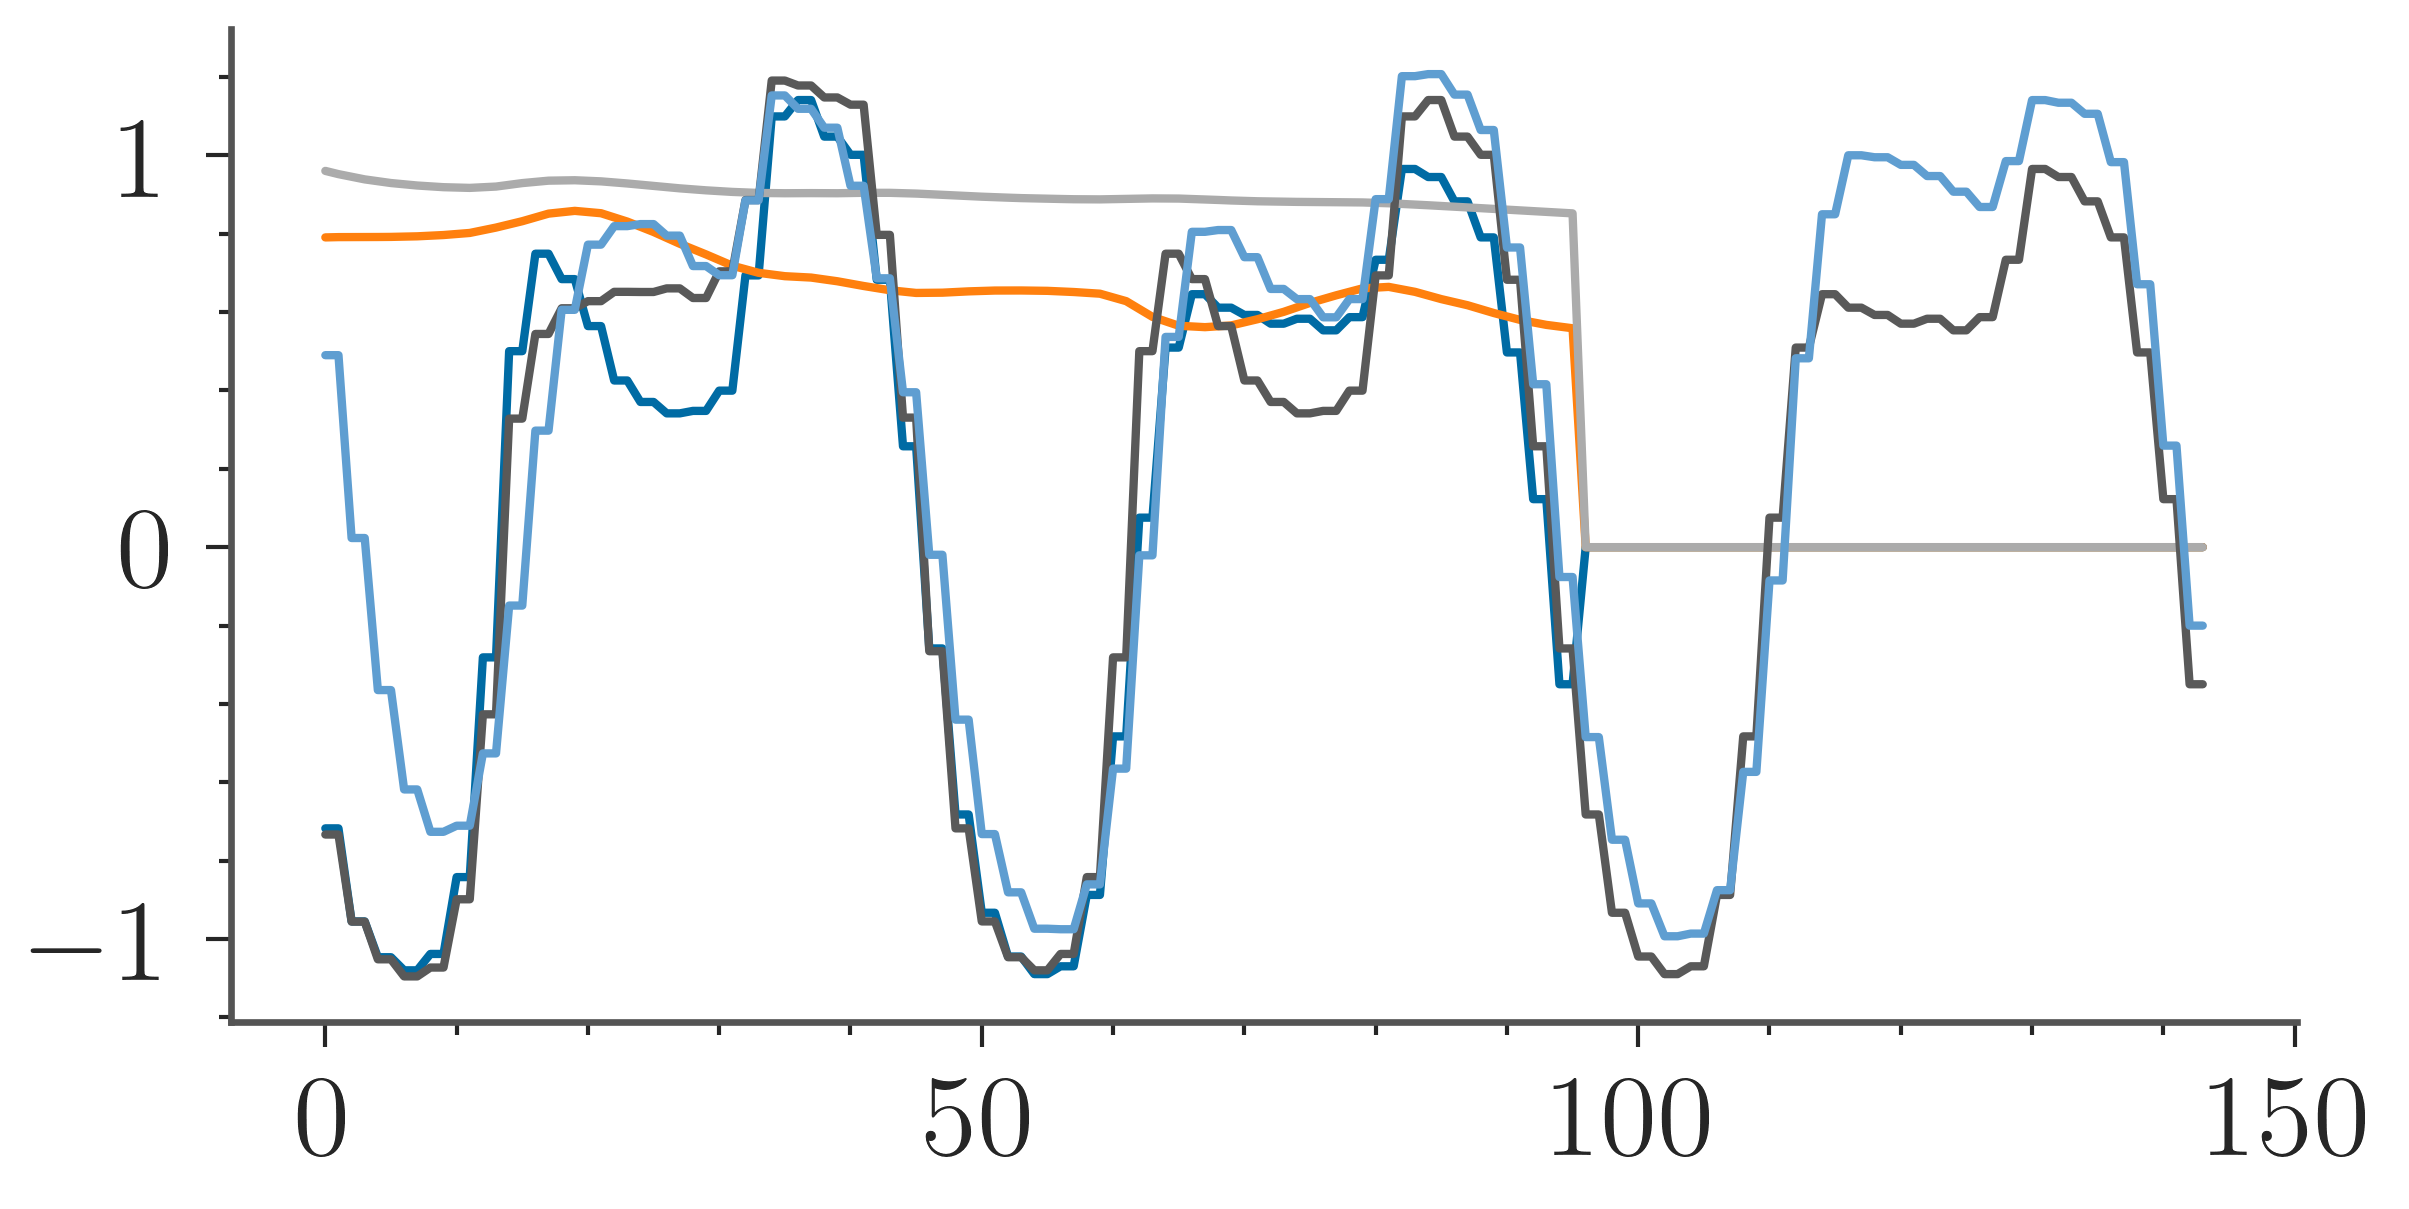

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(x[0, :, :5]);

In [10]:
from mlpforecast.data.loader import TimeseriesDataModule

dl = TimeseriesDataModule(x, y)

In [11]:
x.shape

(69648, 144, 10)

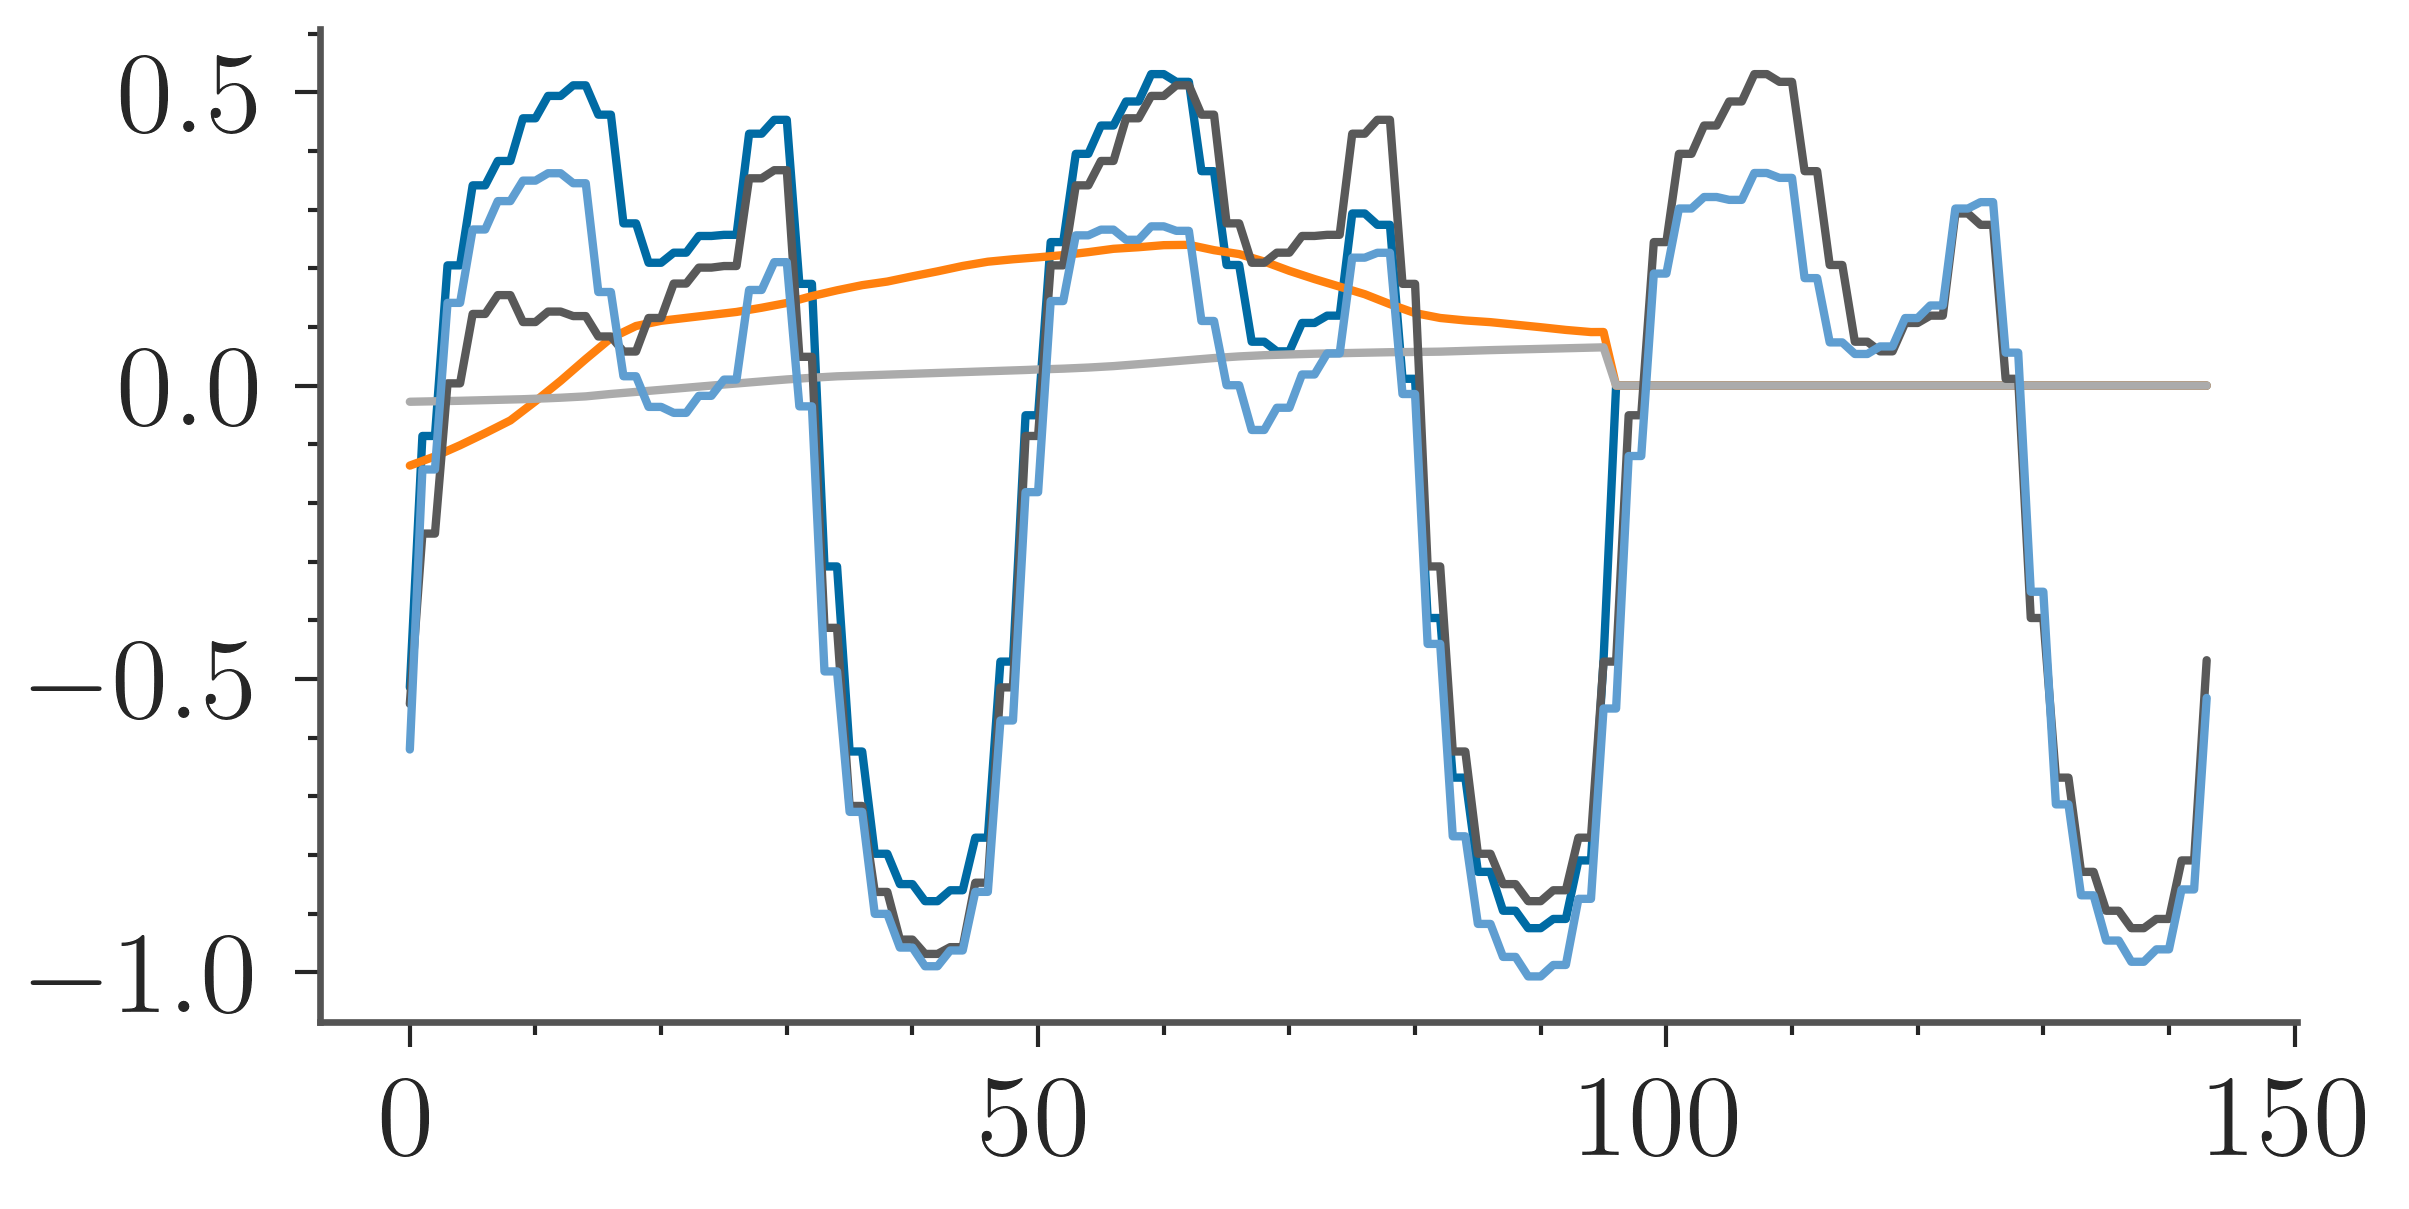

In [12]:
x, y = next(iter(dl.train_dataloader()))
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(x[0, :, :5]);

In [14]:
from mlpforecast.forecaster.mlp import MLPForecast

hparams = {
    "data_pipeline": ds,
    "target_series": "NetLoad",
    "unknown_features": ["NetLoad_rolling_mean_win_48", "NetLoad_rolling_mean_win_336"],
    "known_calender_features": ["HOUR-cosin", "Session-cosin"],
    "known_continuous_features": [
        "NetLoad_lag_48",
        "NetLoad_lag_336",
        "Temperature",
        "Humidity",
        "Rain",
    ],
    "embedding_size": 20,
    "embedding_type": None,
    "combination_type": "additional",
    "hidden_size": 256,
    "num_layers": 2,
    "expansion_factor": 2,
    "residual": False,
    "forecast_horizon": 48,
    "input_window_size": 96,
    "activation_function": "SiLU",
    "out_activation_function": "Identity",
    "dropout_rate": 0.1,
    "alpha": 0.25,
    "max_epochs": 10,
}

model = MLPForecast(hparams=hparams)

In [17]:
model.model.n_out

1

In [18]:
model.fit(data.reset_index()[:20000])

Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:Forecaster:---------------Training started ---------------------------


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ tra_metric_fcn │ MeanAbsoluteError  │      0 │
│ 1 │ val_metric_fcn │ MeanAbsoluteError  │      0 │
│ 2 │ model          │ MLPForecastNetwork │  1.0 M │
└───┴────────────────┴────────────────────┴────────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4

Output()

/Users/anthonyfaustine/opt/anaconda3/envs/MLPF/lib/python3.11/site-packages/torch/autograd/__init__.py:200: 
UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run 
on the CPU. This may have performance implications. (Triggered internally at 
/Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)

INFO:root:training complete after 1.8034379736161403 minutes


108.20627841696842

In [ ]:
x, y = next(iter(model.datamodule.train_dataloader()))

In [ ]:
model.model.eval()
pred = model.model.forecast(x)["pred"]
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(pred[0, :, 0])
ax.plot(y[0, :, 0]);

In [ ]:
from mlpforecast.forecaster.utils import get_latest_checkpoint, format_target

In [ ]:
model.model.data_pipeline

In [ ]:
path_best_model = get_latest_checkpoint(model.checkpoints)
net=model.model.load_from_checkpoint(path_best_model)
net.eval()
model.model.hparams

In [ ]:
test_df=data.reset_index()[20000:20700]
ground_truth = test_df.iloc[net.data_pipeline.max_data_drop:]

In [ ]:
ground_truth = test_df.iloc[self.model.data_pipeline.max_data_drop:]
        time_stamp=ground_truth[self.model.data_pipeline.date_column].values
        time_stamp=format_target(time_stamp, 
                                 self.model.hparams['input_window_size'],
                                 self.model.hparams['forecast_horizon'])
        ground_truth=ground_truth[self.model.data_pipeline.target_series].values
        ground_truth=format_target(ground_truth, 
                                 self.model.hparams['input_window_size'],
                                 self.model.hparams['forecast_horizon'])
        

In [ ]:
model.predict(data.reset_index()[20000:20700])